## Imports and settings

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import pprint

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import pprint
from scipy.stats import gaussian_kde

detector_path = '..'
results_path = os.path.join(detector_path, 'results')
sys.path.append(detector_path)

from utils import constants
from utils import errors
from sleep.mass import MASS
from sleep.inta import INTA
from sleep import postprocessing
from sleep import data_ops
from evaluation import metrics
from evaluation import data_manipulation

DPI = 200

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load database and predicted probabilities

In [2]:
n_seeds = 4

# Select database
dataset_name = constants.MASS_NAME

# Select predictions ckpt folder
ckpt_folder = '20190406_conv_ff'
grid_folder_list = ['avgpool', 'maxpool', 'stridedconv']

append_title = 'Feed-Forward Conv2D'

In [3]:
# Load data
verbose = False
# Marks are binary sequences for each page, 200 fs resolution
errors.check_valid_value(
    dataset_name, 'dataset_name',
    [constants.MASS_NAME, constants.INTA_NAME])
if dataset_name == constants.MASS_NAME:
    dataset = MASS(load_checkpoint=True)
else:
    dataset = INTA(load_checkpoint=True)

# Get training set ids
print('Loading train set... ', end='', flush=True)
all_train_ids = dataset.train_ids
# Get subjects data, with the expert used for training
all_x, all_y = dataset.get_subset_data(all_train_ids, which_expert=1, verbose=verbose)
print('Signals and marks loaded... ', end='', flush=True)
all_pages = dataset.get_subset_pages(all_train_ids, verbose=verbose)
print('Pages loaded.', flush=True)

# Prepare expert labels into marks
print('Preparing labels... ', end='', flush=True)
all_y_stamps = postprocessing.generate_mark_intervals_with_list(
        all_y, all_pages, 200, 200, thr=None, postprocess=False)
print('Done')

Dataset mass with 15 patients.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint... Loaded
Loading train set... Signals and marks loaded... Pages loaded.
Preparing labels... Done


In [4]:
# Load predictions (probability vectors for each page), 200/factor resolution (default factor 8)
seed_list = [123, 234, 345, 456]

set_list = ['train', 'val']
y_pred = {}
for j, folder_name in enumerate(grid_folder_list):
    print('\nGrid setting: %s' % folder_name)
    y_pred[folder_name] = []
    for k in range(n_seeds):
        print('\n%d / %d' % (k+1, n_seeds))
        ckpt_path = os.path.abspath(os.path.join(
            results_path,
            '%s_train_%s' % (ckpt_folder, dataset_name),
            folder_name,
            'seed%d' % k
        ))
        if j==0:
        # Restore seed
            this_seed = seed_list[k]
            print('Validation split seed: %d' % this_seed)
        # Restore predictions
        ckpt_path = os.path.abspath(os.path.join(
            results_path,
            'predictions_%s' % dataset_name,
            '%s_train_%s' % (ckpt_folder, dataset_name),
            folder_name,
            'seed%d' % k
        ))
        print('Loading predictions from %s' % ckpt_path)
        this_dict = {}
        for set_name in set_list:
            this_dict[set_name] = np.load(os.path.join(ckpt_path, 'y_pred_%s.npy' % set_name), allow_pickle=True)
            # Keep only class 1 probability
            this_dict[set_name] = [this_y_pred[..., 1] for this_y_pred in this_dict[set_name]]
        y_pred[folder_name].append(this_dict)
print('\nDone')


Grid setting: avgpool

1 / 4
Validation split seed: 123
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190406_conv_ff_train_mass/avgpool/seed0

2 / 4
Validation split seed: 234
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190406_conv_ff_train_mass/avgpool/seed1

3 / 4
Validation split seed: 345
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190406_conv_ff_train_mass/avgpool/seed2

4 / 4
Validation split seed: 456
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190406_conv_ff_train_mass/avgpool/seed3

Grid setting: maxpool

1 / 4
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190406_conv_ff_train_mass/maxpool/seed0

2 / 4
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/r

## Adjusting threshold

In [5]:
# Performance settings
res_thr = 0.025
start_thr = 0.3
end_thr = 0.5
n_thr = int((end_thr - start_thr) // res_thr + 1)
thr_list = [start_thr + res_thr * i for i in range(n_thr)]
print(thr_list)
print('Number of thresholds to be evaluated: %d' % len(thr_list))

# ---------------- Compute performance
crossval_af1_mean = {}
crossval_af1_std = {}
val_f1 = {}
iou_list = np.arange(1, 10) * 0.1
for folder_name in grid_folder_list:
    print('\nGrid setting: %s' % folder_name)
    crossval_af1_mean[folder_name] = []
    crossval_af1_std[folder_name] = []
    for thr in thr_list:
        print('\nUsing thr %1.4f' % thr)
        val_f1[folder_name] = []
        for k, seed in enumerate(seed_list):
            # Prepare expert labels
            _, val_ids = data_manipulation.split_ids_list(
                all_train_ids, seed=seed)
            print(val_ids)
            val_idx = [all_train_ids.index(this_id) for this_id in val_ids]
            y_thr = [all_y_stamps[i] for i in val_idx]
            pages = [all_pages[i] for i in val_idx]
            # Prepare model predictions
            print('Preparing predictions', flush=True)
            y_pred_thr = postprocessing.generate_mark_intervals_with_list(
                y_pred[folder_name][k]['val'], pages, 200//8, 200, thr=thr)
            # Go through several IoU values
            print('Computing F1 Curve... ', flush=True, end='')
            all_f1_list = [metrics.f1_vs_iou(this_y, this_y_pred, iou_list) 
                           for (this_y, this_y_pred) 
                           in zip(y_thr, y_pred_thr)]
            all_f1_list = np.stack(all_f1_list, axis=1)
            mean_f1 = np.mean(all_f1_list, axis=1)
            val_f1[folder_name].append(mean_f1)
            print('Ready', flush=True)
        val_af1 = np.stack(val_f1[folder_name], axis=1)[2:-1].mean(axis=0)
        crossval_af1_mean[folder_name].append(val_af1.mean())
        crossval_af1_std[folder_name].append(val_af1.std())
    print('Done')

[0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]
Number of thresholds to be evaluated: 9

Grid setting: avgpool

Using thr 0.3000
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Computing F1 Curve... Ready

Using thr 0.3250
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Computing F1 Curve... Ready

Using thr 0.3500
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predict

Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Computing F1 Curve... Ready

Using thr 0.3750
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Computing F1 Curve... Ready

Using thr 0.4000
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing 

avgpool: Optimum at 0.4000 with value 0.7320 +- 0.0386
maxpool: Optimum at 0.4000 with value 0.7281 +- 0.0373
stridedconv: Optimum at 0.3750 with value 0.7295 +- 0.0393


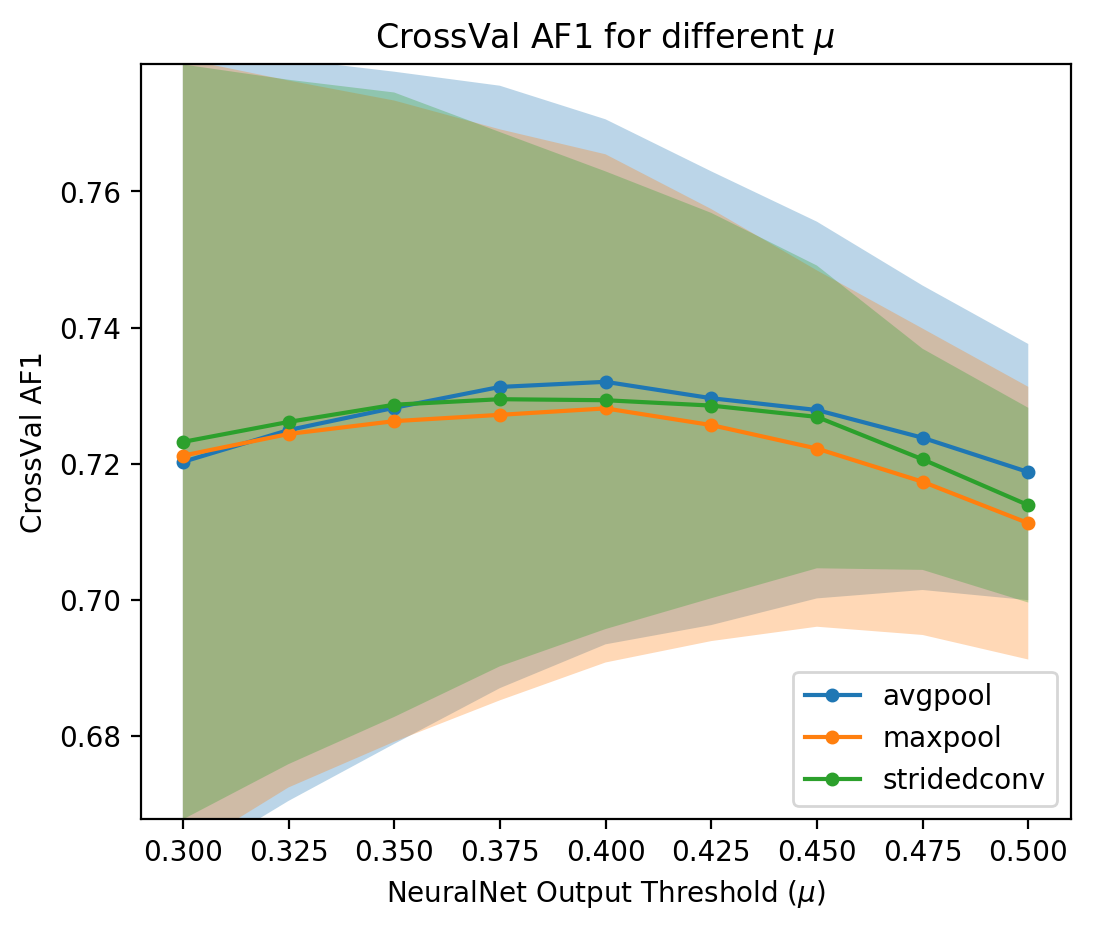

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=200)

ax.set_title('CrossVal AF1 for different $\mu$')
max_y = 1
min_y = 0
for j, folder_name in enumerate(grid_folder_list):
    max_idx = np.argmax(np.array(crossval_af1_mean[folder_name]))
    print('%s: Optimum at %1.4f with value %1.4f +- %1.4f' % (
        folder_name, 
        thr_list[max_idx], 
        crossval_af1_mean[folder_name][max_idx], 
        crossval_af1_std[folder_name][max_idx]))
    ax.plot(thr_list, crossval_af1_mean[folder_name], label=folder_name, marker='.', markersize=8, linewidth=1.5, color='C%d' % j)
    ax.fill_between(
        thr_list, 
        np.array(crossval_af1_mean[folder_name]) + np.array(crossval_af1_std[folder_name]), 
        np.array(crossval_af1_mean[folder_name]) - np.array(crossval_af1_std[folder_name]), 
        facecolor='C%d' % j, alpha=0.3)
    max_y = min(max_y,  np.max(np.array(crossval_af1_mean[folder_name]) + np.array(crossval_af1_std[folder_name])))
    min_y = max(min_y,  np.min(np.array(crossval_af1_mean[folder_name]) - np.array(crossval_af1_std[folder_name])))
ax.set_ylim([min_y, max_y])
ax.set_ylabel('CrossVal AF1')
ax.set_xlabel('NeuralNet Output Threshold ($\mu$)')
ax.legend(loc='lower right')
plt.show()

## Validation performance: F1 vs IoU

In [5]:
# Performance settings
# thr = 0.5
thr = 0.4

# ---------------- Compute performance
print('Using thr %1.4f' % thr)

val_f1 = {}
iou_list = np.arange(1, 10) * 0.1
for folder_name in grid_folder_list:
    print('\nGrid setting: %s' % folder_name)
    val_f1[folder_name] = []
    for k, seed in enumerate(seed_list):
        # Prepare expert labels
        _, val_ids = data_manipulation.split_ids_list(
            all_train_ids, seed=seed)
        print(val_ids)
        val_idx = [all_train_ids.index(this_id) for this_id in val_ids]
        y_thr = [all_y_stamps[i] for i in val_idx]
        pages = [all_pages[i] for i in val_idx]
        # Prepare model predictions
        print('Preparing predictions', flush=True)
        y_pred_thr = postprocessing.generate_mark_intervals_with_list(
            y_pred[folder_name][k]['val'], pages, 200//8, 200, thr=thr)
        # Go through several IoU values
        print('Computing F1 Curve... ', flush=True, end='')
        all_f1_list = [metrics.f1_vs_iou(this_y, this_y_pred, iou_list) 
                       for (this_y, this_y_pred) 
                       in zip(y_thr, y_pred_thr)]
        all_f1_list = np.stack(all_f1_list, axis=1)
        mean_f1 = np.mean(all_f1_list, axis=1)
        val_f1[folder_name].append(mean_f1)
        print('Ready', flush=True)
print('Done')

Using thr 0.4000

Grid setting: avgpool
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Computing F1 Curve... Ready

Grid setting: maxpool
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Computing F1 Curve... Ready

Grid setting: stridedconv
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Computing F1 Curve... Ready
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Prepa


Grid setting: avgpool
[0.7963657914251441,
 0.7961025479581515,
 0.7946591214177215,
 0.7904452307393558,
 0.7814712851076295,
 0.7635875444700903,
 0.7106814778392364,
 0.5513181409171256,
 0.21787628233067266]
IoU list for AF1: [0.3 0.4 0.5 0.6 0.7 0.8]
[0.66885372 0.73783936 0.74880005 0.77261541]
Val AF1: 0.7320 +- 0.0386

Grid setting: maxpool
[0.793029824503537,
 0.7928667620397266,
 0.7913748421555471,
 0.7872337722191723,
 0.7775785960894138,
 0.7590057022007284,
 0.7076620302356295,
 0.5458750192741554,
 0.21988470779489366]
IoU list for AF1: [0.3 0.4 0.5 0.6 0.7 0.8]
[0.66906917 0.72436841 0.75231756 0.76673151]
Val AF1: 0.7281 +- 0.0373

Grid setting: stridedconv
[0.796783900963964,
 0.7966226366517563,
 0.7949802778235685,
 0.7885470744143949,
 0.7776149977509051,
 0.7591305703708993,
 0.7040261150686327,
 0.5516332189197825,
 0.21652335894459587]
IoU list for AF1: [0.3 0.4 0.5 0.6 0.7 0.8]
[0.67374076 0.73265983 0.7500206  0.76086699]
Val AF1: 0.7293 +- 0.0336


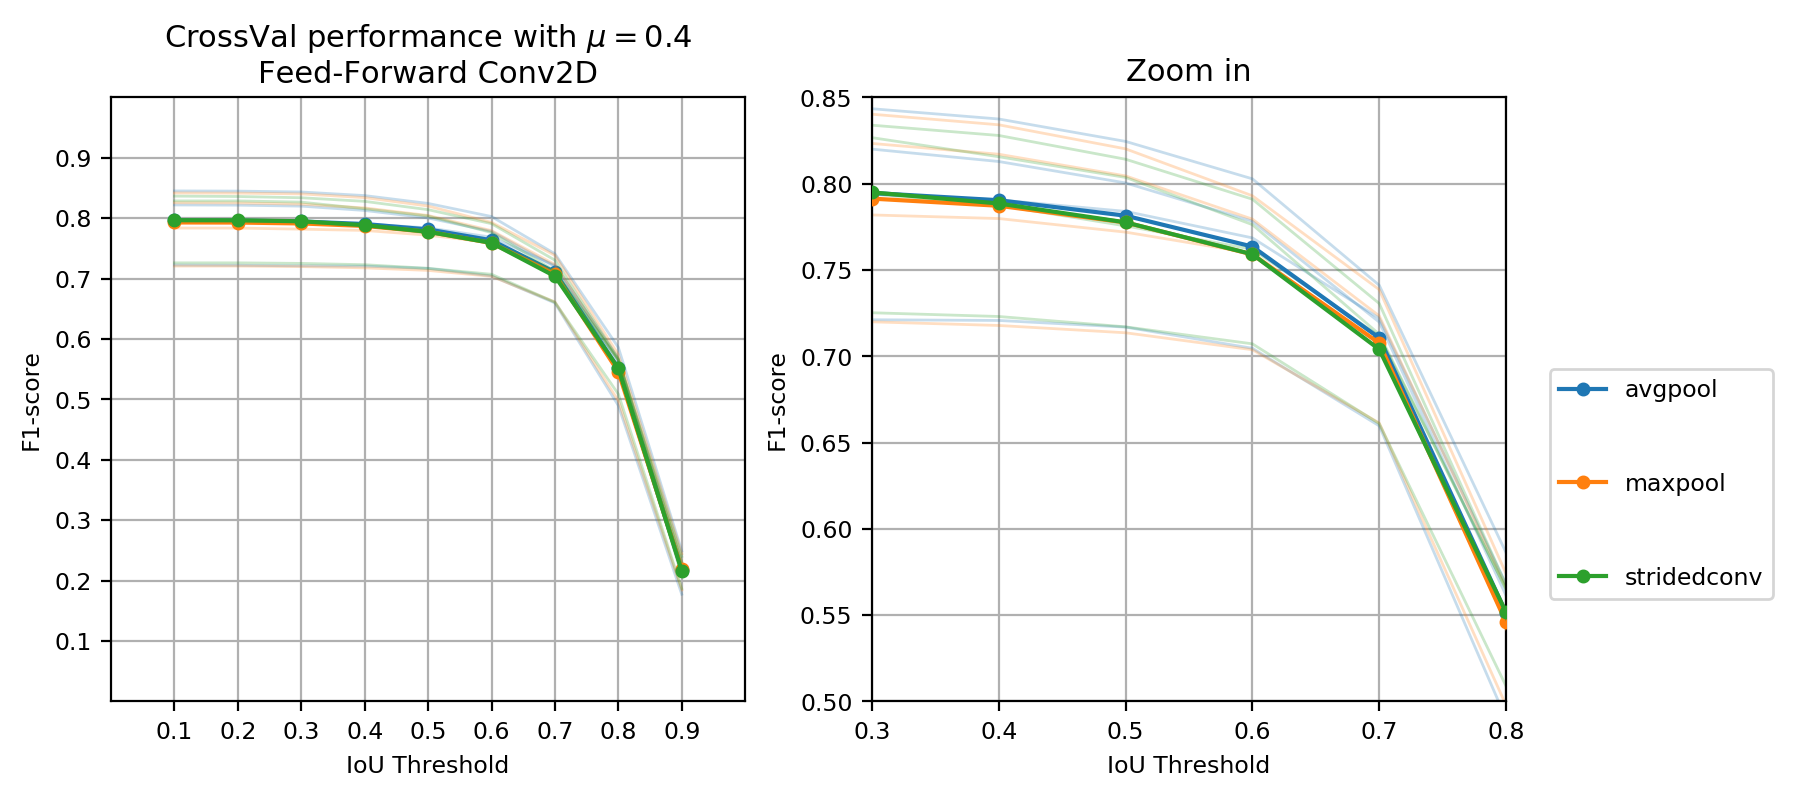

In [6]:
# Comparison settings
alpha = 0.2
color_list = {}
for k, folder_name in enumerate(grid_folder_list):
    color_list[folder_name] = 'C%d' % k
zoom_xlim = [0.3, 0.8]
zoom_ylim = [0.5, 0.85]
linewidth_mean = 1.5
markersize_mean = 8
linewidth_single = 1
markersize_single = 8

# -------------------- P L O T ----------------------    
fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=DPI)

# Complete plot
for folder_name in grid_folder_list:
    for k in range(n_seeds):
        ax[0].plot(iou_list, val_f1[folder_name][k], 
                   linewidth=linewidth_single, markersize=markersize_single, 
                   color=color_list[folder_name], alpha=0.25)
    mean_val_f1 = np.stack(val_f1[folder_name], axis=1).mean(axis=1)
    print('\nGrid setting: %s' % folder_name)
    pprint.pprint(mean_val_f1.tolist())
    print('IoU list for AF1:', iou_list[2:-1])
    val_af1 = np.stack(val_f1[folder_name], axis=1)[2:-1].mean(axis=0)
    print(val_af1)
    print('Val AF1: %1.4f +- %1.4f' % (val_af1.mean(), val_af1.std()))
    ax[0].plot(iou_list, mean_val_f1, 
           linewidth=linewidth_mean, markersize=markersize_mean, marker='.',
           color=color_list[folder_name])
ax[0].set_title('CrossVal performance with $\mu=%1.1f$\n%s' % (thr, append_title), fontsize=11)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0.1*i for i in range(1, 10)])
ax[0].set_xticks([0.1*i for i in range(1, 10)])
ax[0].tick_params(labelsize=8.5)
ax[0].set_xlabel('IoU Threshold', fontsize=8.5)
ax[0].set_ylabel('F1-score', fontsize=8.5)
ax[0].grid()

# Zoom plot
for folder_name in grid_folder_list:
    for k in range(n_seeds):
        ax[1].plot(iou_list, val_f1[folder_name][k], 
                   linewidth=linewidth_single, markersize=markersize_single, 
                   color=color_list[folder_name], alpha=0.25)
    mean_val_f1 = np.stack(val_f1[folder_name], axis=1).mean(axis=1)
    ax[1].plot(iou_list, mean_val_f1, 
           linewidth=linewidth_mean, markersize=markersize_mean, marker='.',
           color=color_list[folder_name], label=folder_name, zorder=10)
ax[1].set_title('Zoom in', fontsize=11)
ax[1].set_xlim(zoom_xlim)
ax[1].set_ylim(zoom_ylim)
ax[1].tick_params(labelsize=8.5)
ax[1].set_xlabel('IoU Threshold', fontsize=8.5)
ax[1].set_ylabel('F1-score', fontsize=8.5)
ax[1].legend(loc='lower left', bbox_to_anchor=(1.05, 0.15), labelspacing=3, fontsize=8.5)
ax[1].grid()

plt.show()

## Tuning threshold by cross-validation and "negative" events

In [7]:
# Performance settings
thr = 0.1 # we use a low threshold to generate negative events

print('Using thr %1.4f' % thr)
matching_proba = {}
unmatching_fp_proba = {}
iou_list = np.arange(1, 10) * 0.1
for folder_name in grid_folder_list:
    print('\nGrid setting: %s' % folder_name)
    
    matching_proba[folder_name] = []
    unmatching_fp_proba[folder_name] = []
    for k, seed in enumerate(seed_list):
        # Prepare expert labels
        _, val_ids = data_manipulation.split_ids_list(
            all_train_ids, seed=seed)
        print(val_ids)
        val_idx = [all_train_ids.index(this_id) for this_id in val_ids]
        y_thr = [all_y_stamps[i] for i in val_idx]
        pages = [all_pages[i] for i in val_idx]
        n_subjects = len(y_thr)
        # Prepare model predictions
        print('Preparing predictions', flush=True)
        y_pred_thr = postprocessing.generate_mark_intervals_with_list(
            y_pred[folder_name][k]['val'], pages, 200//8, 200, thr=thr)
        # matching
        whole_y_proba = []
        matching_proba[folder_name].append([])
        unmatching_fp_proba[folder_name].append([])
        for i in range(n_subjects):
            events = y_thr[i]
            detections = y_pred_thr[i]
            this_iou_array, this_idx_array = metrics.matching(events, detections)
            # Prepare probabilities
            this_proba = y_pred[folder_name][k]['val'][i]
            this_pages = pages[i]
            page_size = this_proba.shape[1]
            max_page = np.max(this_pages)
            max_size = (max_page + 1) * page_size
            whole_y_proba.append(np.zeros(max_size, dtype=np.float32))
            for j, page in enumerate(this_pages):
                sample_start = page * page_size
                sample_end = (page + 1) * page_size
                whole_y_proba[i][sample_start:sample_end] = this_proba[j, :]
    
            # In this case, we look for the valid detections stamps 
            idx_valid = (this_idx_array > -1)
            y_pred_stamps = detections[this_idx_array][idx_valid]
            # And now we need to get the probabilities inside those stamps
            # First, we downsample the stamps
            y_pred_stamps = y_pred_stamps // 8
            # Now, we get the mean probability between stamps
            mean_proba_list = []
            for stamp in y_pred_stamps:
                proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
                mean_proba_inside = proba_inside.mean()
                mean_proba_list.append(mean_proba_inside)
            mean_proba_list = np.array(mean_proba_list)
            matching_proba[folder_name][k].append(mean_proba_list)
            
            # In this case, we look for detected events with no match 
            n_detections = detections.shape[0]
            idx_valid = [idx for idx in range(n_detections) if (idx not in this_idx_array)]
            fp_stamps = detections[idx_valid]
            # And now we need to get the probabilities inside those stamps
            # First, we downsample the stamps
            fp_stamps = fp_stamps // 8
            # Now, we get the mean probability between stamps
            mean_proba_list = []
            for stamp in fp_stamps:
                proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
                mean_proba_inside = proba_inside.mean()
                mean_proba_list.append(mean_proba_inside)
            mean_proba_list = np.array(mean_proba_list)
            unmatching_fp_proba[folder_name][k].append(mean_proba_list)

print('Done')

Using thr 0.1000

Grid setting: lstm_128_fc_64
Split IDs: Total 11 -- Training 8
[11, 19, 5]
Preparing predictions
Split IDs: Total 11 -- Training 8
[3, 9, 17]
Preparing predictions
Split IDs: Total 11 -- Training 8
[7, 1, 17]
Preparing predictions
Split IDs: Total 11 -- Training 8
[9, 18, 10]
Preparing predictions
Done



Grid setting: lstm_128_fc_64
Optimal Threshold: 0.4450

List of optimal threshold:  [0.445]

Mean optimal threshold of grid: 0.4450


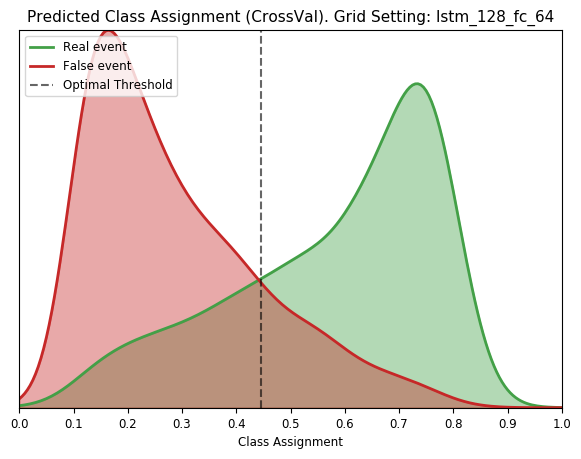

In [9]:
# --- Avg distributions over set
# --- Histogram of probabilities

n_points = 200
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(len(grid_folder_list), 1, figsize=(7, 5*len(grid_folder_list)), dpi=100, sharex=True)

optimal_thr = []

for j, folder_name in enumerate(grid_folder_list):
    if len(grid_folder_list) > 1:
        this_ax = ax[j]
    else:
        this_ax = ax
    print('\nGrid setting: %s' % folder_name)
    curve_real = []
    curve_false = []
    for k, seed in enumerate(seed_list):

        y_kde_list = []
        for i in range(n_subjects):
            kernel = gaussian_kde(matching_proba[folder_name][k][i])
            y_kde = kernel(x_points)
            y_kde_list.append(y_kde)
        y_kde_avg_real = np.stack(y_kde_list, axis=1).mean(axis=1)
        curve_real.append(y_kde_avg_real)
        
        y_kde_list = []
        for i in range(n_subjects):
            kernel = gaussian_kde(unmatching_fp_proba[folder_name][k][i])
            y_kde = kernel(x_points)
            y_kde_list.append(y_kde)
        y_kde_avg_false = np.stack(y_kde_list, axis=1).mean(axis=1)
        curve_false.append(y_kde_avg_false)
    
    curve_real = np.stack(curve_real, axis=1).mean(axis=1)
    curve_false = np.stack(curve_false, axis=1).mean(axis=1)
    
    this_ax.set_title('Predicted Class Assignment (CrossVal). Grid Setting: %s' % folder_name, fontsize=11)
    this_ax.plot(x_points, curve_real, color='#43a047', linewidth=2, label='Real event')
    this_ax.fill_between(x_points, curve_real, 0*curve_real, color='#43a047', alpha=0.4)
    this_ax.plot(x_points, curve_false, color='#c62828', linewidth=2, label='False event')
    this_ax.fill_between(x_points, curve_false, 0*curve_false, color='#c62828', alpha=0.4)

    max_y = max(np.max(curve_real), np.max(curve_false))

    # Find optimal threshold
    difference = curve_false - curve_real
    idx_thr = np.where(np.signbit(difference))[0][0]
    x_thr = x_points[idx_thr]
    optimal_thr.append(x_thr)
    print('Optimal Threshold: %1.4f' % x_thr)
    this_ax.plot([x_thr, x_thr], [0, max_y], '--', color='k', linewidth=1.5, alpha=0.6, label='Optimal Threshold')

    this_ax.tick_params(labelsize=8.5)
    this_ax.set_xlim([0, 1])
    this_ax.set_ylim([0, max_y])
    this_ax.set_yticks([])
    this_ax.legend(fontsize=8.5, loc='upper left')
    this_ax.set_xlabel('Class Assignment', fontsize=8.5)
    this_ax.set_xticks([i*0.1 for i in range(11)])

print('\nList of optimal threshold: ', optimal_thr)
print('\nMean optimal threshold of grid: %1.4f' % np.mean(optimal_thr))
plt.show()
